#  Tradutor de Textos - Experimento
## Utilização do modelo [MarianMT](https://huggingface.co/transformers/model_doc/marian.html) para tradução. 


* Este componente faz tradução multilingual entre uma série de idiomas, tais como Português, Inglês, Espanhol, Alemão, Holandês, Japonês, Chinês e outros. 
* Para adaptar para traduções em outros idiomas é necessário verificacar se há o modelo pré treinado disponível no MarianMT e adicionar o par de tradução (idioma fonte, idioma alvo) no arquivo ```translator.py``` da seguinte forma:
    
    ```python
    # Par de tradução e respectivo modelo
    MODEL_MAP = {
        ...
        ('português', 'inglês'): 'Helsinki-NLP/opus-mt-ROMANCE-en',
        ...
    }

    ...

    # Código dos idiomas inseridos (se não houver)
    LANGUAGE_PREFIX = {
        ...
        'português': 'pt',
        'inglês': 'en',
        ...
    }
    ...
    ```

* As métricas computadas são o BLEU e o ROUGE-L 


### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [44]:
dataset = "/tmp/data/texts-20.csv" #@param {type:"string"}
text_column_name = "text" #@param {type:"string", label:"Coluna para aplicar o Tradutor", description:"Esta coluna será utilizada para traduzir os textos. Deve ser uma coluna existente do dataset."}
output_column_name = "text_translated" #@param {type:"string", label:"Coluna para salvar os textos traduzidos", description:"Esta coluna será utilizada para salvar as traduções dos textos. Deve ser uma coluna inexistente do dataset."}
expected_column_name = "" #@param {type:"string", label:"Coluna para avaliar os textos traduzidos", description:"Esta coluna será utilizada para avaliar as traduções dos textos. É uma coluna opcional."}
source_language = "português" #@param ["africâner","alemão", "árabe", "catalão", "chinês", "dinamarquês", "espanhol", "francês", "frísio", "holandês", "híndi", "inglês", "islandês", "italiano", "japonês", "latim", "norueguês", "português", "romeno", "sueco", "zulu"] {type:"string",multiple:false,label:"Idioma Fonte",description:"Idioma dos dados de entrada."}
target_language = "inglês" #@param ["africâner","alemão", "árabe", "catalão", "chinês", "dinamarquês", "espanhol", "francês", "frísio", "holandês", "híndi", "inglês", "islandês", "italiano", "japonês", "latim", "norueguês", "português", "romeno", "sueco", "zulu"] {type:"string",multiple:false,label:"Idioma Alvo",description:"Idioma dos dados de saída."}
device = "cuda" #@param ["cuda","cpu"] {type:"string",multiple:false,label:"Dispositivo",description:"Tipo de dispositivo para efetuar as traduções."}
batch_size = 4 #@param {type:"number",label:"Batch Size",description:"Tamanho dos lotes de dados para tradução."}

## Leitura do conjunto de dados

O exemplo abaixo faz a leitura de dados tabulares (ex: .csv).<br>
Modifique o código de acordo com o tipo de dado que desejar ler.

In [45]:
import pandas as pd

df = pd.read_csv(dataset)
df

,index,text,expected_text
0,1,A bola é um objeto utilizado para lazer de uma...,A ball is an object used for a person's leisur...
1,2,Golfe é um esporte no qual os jogadores usam d...,Golf is a sport in which players use different...
2,3,"Jogo por tacadas[1] (stroke play[2]), também c...","Stroke play[1] (stroke play[2]), also known as..."


## Conteúdo da tarefa

In [46]:
# Assert parameters

assert text_column_name in df.columns, f"Coluna '{text_column_name}' deve ser uma coluna do dataset."
assert output_column_name not in df.columns, f"Coluna '{output_column_name}' não pode estar contida nas colunas do dataset."
assert expected_column_name == "" or expected_column_name in df.columns, f"Coluna '{expected_column_name}' deve ser uma coluna do dataset ou deixar ou campo em branco."
assert device in ['cuda', 'cpu'], f"Dispositivo '{device}' deve ser ou 'cuda' ou 'cpu'."
assert source_language != target_language, f"Os idiomas de fonte e alvo devem ser diferentes."
assert batch_size > 0, f"O Batch Size deve ser maior do que 0."

In [47]:
import torch

# Model parameters
model_parameters = {
    'device':torch.device(device) if torch.cuda.is_available() else torch.device('cpu'),
    'source_language':source_language,
    'target_language':target_language,
}

# Inference parameters
inference_parameters = {
    'text_column_name':text_column_name,
    'output_column_name':output_column_name,
    'expected_column_name':expected_column_name,
    'columns':list(df.columns),
    'batch_size': batch_size
}

In [48]:
from translator import Translator

# Initialize translator
translator = Translator(**model_parameters)

# Make inference
translated_sentences = translator(
    batch_sentence=df[inference_parameters['text_column_name']].values, 
    batch_size=inference_parameters['batch_size']
)

del translator

In [49]:
# Save to dataframe
df[inference_parameters['output_column_name']] = translated_sentences

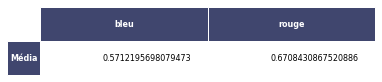

In [62]:
from platiagro.metrics_nlp import wrapper
from platiagro.plotting import plot_data_table
# Evaluate translation (Optional)

# Iff is not empty
if inference_parameters['expected_column_name'] != "":
    
    # Initializate calculator
    calculator = wrapper.MetricsCalculator(metrics=['bleu', 'rouge'])
    
    # Perform calculations
    scores = calculator.calculate_from_texts(
        df[inference_parameters['output_column_name']].values, 
        df[inference_parameters['expected_column_name']].values
    )
    
    # Plot metrics
    plot_data_table(pd.DataFrame(scores, index = ['Média']))

In [10]:
# Save data
df.to_csv(dataset, index=False)

## Salva resultados da tarefa

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.<br>
Use essa pasta para salvar modelos, metadados e outros resultados.

In [7]:
from joblib import dump

artifacts = {
    "model_parameters": model_parameters,
    "inference_parameters": inference_parameters
}

dump(artifacts, "/tmp/data/translator.joblib")

['/tmp/data/translator.joblib']

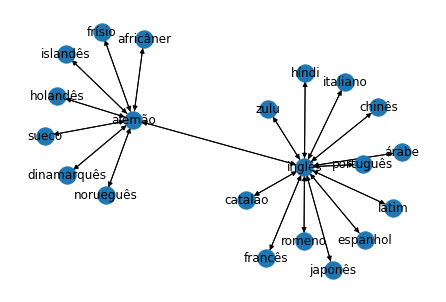

In [5]:
# from translator import LANGUAGE_GRAPH
# import networkx as nx

# nx.draw(LANGUAGE_GRAPH, with_labels = True)